In [1]:
using DifferentialEquations, DataFrames, Plots, Sundials

In [2]:
function ribofinal(dydt, init, parameters, t)

    dm, kb, ku, Kp, thetar, kq, thetax, wr0, wq0, we0, gmax, aatot, vt, Kt, s0, vm, Km, ns, nq, nr, nx, b, cl, k_cm = parameters
    a, em, et, mm, mq, mr, mt, eq, er, rmm, rmq, rmr, rmt, si, zmm, zmq, zmr, zmt = init
    
    #define change arrays
    da, dem, det, dmm, dmq, dmr, dmt, deq, der, drmm, drmq, drmr, drmt, dsi, dzmm, dzmq, dzmr, dzmt = zeros(length(dydt))
    
    # import
    # s0 -> si; following a Michaelis-Menten dynamic: et*vt*s0/(Kt+s0)
    imp = (et*vt*s0/(Kt + s0))
    
    dsi = dsi + imp
    
    # metabolism
    # si -> a; following a Michaelis-Menten dynamic: em*vm*si/(Km + si)
    nucat= em*vm*si/(Km + si)
    
    da = da +nucat * ns
    dsi = dsi -nucat
        
    # transcription 
    # 0 -> rx; following a Michaelis-Menten dynamic: x*a/(theta+a)
    function transcriptionMM(wx,theta) wx*a/(theta+a) end
    
    dmm = dmm +transcriptionMM(we0,thetax)
    dmr = dmr +transcriptionMM(wr0,thetar)
    dmt = dmt +transcriptionMM(we0,thetax)
    
    # q-compartment inhibition
    # In the case of compartment q, included autoinhibition 1+(q/kq^nq)
    qMM = 1+(eq/kq)^nq

    dmq = dmq + transcriptionMM(wq0,thetax)/qMM   
    
    # translation
    
    ## binding
    # rx + r <-> rmx; at forward rate: kb*rx*r
    #                  at backward rate: ku*rmx

    function bind(mx) mx*er*kb end
    function unbind(rmx) rmx*ku end

    dmm = dmm + unbind(rmm) -bind(mm)
    dmq = dmq + unbind(rmq) -bind(mq)
    dmr = dmr + unbind(rmr) -bind(mr)
    dmt = dmt + unbind(rmt) -bind(mt)
    der = der + unbind(rmr+rmt+rmm+rmq) -bind(mr+mt+mm+mq)
    drmm = drmm -unbind(rmm) +bind(mm)
    drmq = drmq -unbind(rmq) +bind(mq)
    drmr = drmr -unbind(rmr) +bind(mr)
    drmt = drmt -unbind(rmt) +bind(mt)
      
    ## main part and release
    # rmx + nx * a ->  x + r; at forward rate: gmax*a/(Kg + a)
    
    Kg= gmax/Kp
    gamma= gmax*a/(Kg + a)

    function transRate(transRibo,protLen) transRibo*gamma/protLen end
    
    da = da -gamma*(rmq + rmr + rmt + rmm)
    dem = dem +  transRate(rmm,nx)
    deq = deq +  transRate(rmq,nx)
    der = der +2*transRate(rmr,nr) +transRate(rmt+rmm+rmq,nx)
    det = det +  transRate(rmt,nx)
    drmm = drmm -transRate(rmm,nx)
    drmq = drmq -transRate(rmq,nx)
    drmr = drmr -transRate(rmr,nr)
    drmt = drmt -transRate(rmt,nx)
    
    # degradation
    # mx -> 0; at a rate dm*mx
    function degrade(mx) dm*mx end
    dmm = dmm -degrade(mm)
    dmq = dmq -degrade(mq)
    dmr = dmr -degrade(mr)
    dmt = dmt -degrade(mt)
    
    # growth rate
    ttrate= (rmq + rmr + rmt + rmm)*gamma
    lam= ttrate/aatot

    # chloramphenicol
    # rmx <-> zmx ; at a forward rate cl*k_cm and backward b=0
    f = cl*k_cm
    
    function inhibit(rmx) f*rmx end
    function uninhibit(zmx) b*zmx end
    
    drmm = drmm -inhibit(rmm) +uninhibit(zmm)
    drmq = drmq -inhibit(rmq) +uninhibit(zmq)
    drmr = drmr -inhibit(rmr) +uninhibit(zmr)
    drmt = drmt -inhibit(rmt) +uninhibit(zmt)
    dzmm = dzmm +inhibit(rmm) -uninhibit(zmm)
    dzmq = dzmq +inhibit(rmq) -uninhibit(zmq)
    dzmr = dzmr +inhibit(rmr) -uninhibit(zmr)
    dzmt = dzmt +inhibit(rmt) -uninhibit(zmt)
    
    # dilution
    # x -> 0; at a rate lam*x
    function dilute(x) lam*x end

    da = da -dilute(a)
    dem = dem -dilute(em)
    det = det -dilute(et)
    dmm = dmm -dilute(mm)
    dmq = dmq -dilute(mq)
    dmr = dmr -dilute(mr)
    dmt = dmt -dilute(mt)
    deq = deq -dilute(eq)
    der = der -dilute(er)
    drmm = drmm -dilute(rmm)
    drmq = drmq -dilute(rmq)
    drmr = drmr -dilute(rmr)
    drmt = drmt -dilute(rmt)
    dsi = dsi -dilute(si)
    dzmm = dzmm - dilute(dzmm)
    dzmq = dzmq - dilute(dzmq)
    dzmr = dzmr - dilute(dzmr)
    dzmt = dzmt - dilute(dzmt)
    

    
    dydt[1] = da
    dydt[2] = dem
    dydt[3] = det
    dydt[4] = dmm
    dydt[5] = dmq
    dydt[6] = dmr
    dydt[7] = dmt
    dydt[8] = deq
    dydt[9] = der
    dydt[10] = drmm
    dydt[11] = drmq
    dydt[12] = drmr
    dydt[13] = drmt
    dydt[14] = dsi
    dydt[15] = zmm
    dydt[16] = zmq
    dydt[17] = zmr
    dydt[18] = zmt

end 


ribofinal (generic function with 1 method)

In [12]:
# parameters

# define rate constants
dm= 0.1
kb= 1.0
ku= 1.0

Kp= 7.0
thetar= 426.87
kq= 152219.
thetax= 4.38
wr0= 93.
wq0= 949.
we0= 4.38
gmax= 1260.0
aatot= 1.0e8
vt= 726.0
Kt= 1.0e3
s0= 1.0e4
vm= 5800.0
Km= 1.0e3
ns= 1.
nq= 4.
nr= 7549.0
nx= 300.0
b = 0.0
cl= 0.0
k_cm = 0.00554752/662.435565

parameters= [dm, kb, ku, Kp, thetar, kq, thetax, wr0, wq0, we0, gmax, aatot, vt, Kt, s0, vm, Km, ns, nq, nr, nx, b, cl, k_cm]

# define initial conditions
a_0= 1000.0
em_0= 10
et_0= 10
mm_0= 10
mq_0= 10
mr_0= 10
mt_0= 10
eq_0= 10
er_0= 10.0
rmm_0= 0
rmt_0= 0
rmq_0= 0
rmr_0= 0
si_0= 0
zmm_0= 0
zmq_0= 0
zmr_0= 0
zmt_0= 0

init= [a_0, em_0, et_0, mm_0, mq_0, mr_0, mt_0, eq_0, er_0, rmm_0, rmt_0, rmq_0, rmr_0, si_0, zmm_0, zmq_0, zmr_0, zmt_0]
species = [:a, :em, :et, :mm, :mq, :mr, :mt, :eq, :er, :rmm, :rmq, :rmr, :rmt, :si, :zmm, :zmq, :zmr, :zmt]


tspan = (0.,10000.)
prob = ODEProblem(ribofinal,init,tspan,parameters)

sol = solve(prob)


solDF = DataFrame([[j[i] for j in sol.u] for i=1:length(sol.u[1])], species)



563×18 DataFrame. Omitted printing of 12 columns
│ Row │ a       │ em      │ et      │ mm          │ mq       │ mr        │
│     │ Float64 │ Float64 │ Float64 │ Float64     │ Float64  │ Float64   │
├─────┼─────────┼─────────┼─────────┼─────────────┼──────────┼───────────┤
│ 1   │ 1000.0  │ 10.0    │ 10.0    │ 10.0        │ 10.0     │ 10.0      │
│ 2   │ 1000.0  │ 10.0    │ 10.0    │ 9.99996     │ 10.0004  │ 9.99998   │
│ 3   │ 1000.0  │ 10.0    │ 10.0    │ 9.99952     │ 10.0042  │ 9.99982   │
│ 4   │ 1000.0  │ 10.0    │ 10.0    │ 9.99513     │ 10.0425  │ 9.9982    │
│ 5   │ 999.994 │ 10.0    │ 10.0    │ 9.95187     │ 10.4254  │ 9.98248   │
│ 6   │ 999.815 │ 10.0011 │ 10.0011 │ 9.76757     │ 12.1573  │ 9.9221    │
│ 7   │ 998.46  │ 10.007  │ 10.007  │ 9.45957     │ 15.527   │ 9.85187   │
│ 8   │ 993.769 │ 10.0217 │ 10.0217 │ 9.13013     │ 20.187   │ 9.84476   │
│ 9   │ 982.778 │ 10.0484 │ 10.0484 │ 8.83804     │ 26.1562  │ 9.95626   │
│ 10  │ 962.899 │ 10.0886 │ 10.0886 │ 8.61919     │ 33.5313  │ 10.2246   │
⋮
│ 553 │ 424.193 │ 809.724 │ 809.724 │ 0.000757161 │ 0.115014 │ 0.0554053 │
│ 554 │ 424.192 │ 809.726 │ 809.726 │ 0.000755929 │ 0.114828 │ 0.0553151 │
│ 555 │ 424.191 │ 809.727 │ 809.727 │ 0.000755187 │ 0.114716 │ 0.0552608 │
│ 556 │ 424.191 │ 809.727 │ 809.727 │ 0.000754795 │ 0.114656 │ 0.0552321 │
│ 557 │ 424.191 │ 809.727 │ 809.727 │ 0.000754622 │ 0.11463  │ 0.0552195 │
│ 558 │ 424.191 │ 809.727 │ 809.727 │ 0.000754565 │ 0.114621 │ 0.0552153 │
│ 559 │ 424.191 │ 809.727 │ 809.727 │ 0.000754553 │ 0.11462  │ 0.0552144 │
│ 560 │ 424.191 │ 809.727 │ 809.727 │ 0.000754552 │ 0.114619 │ 0.0552143 │
│ 561 │ 424.191 │ 809.727 │ 809.727 │ 0.000754552 │ 0.114619 │ 0.0552143 │
│ 562 │ 424.191 │ 809.727 │ 809.727 │ 0.000754552 │ 0.114619 │ 0.0552143 │
│ 563 │ 424.191 │ 809.727 │ 809.727 │ 0.000754552 │ 0.114619 │ 0.0552143 │

In [15]:
function calculateLambda(finalState, parameters)
    Kg= gmax/Kp
    a = finalState[:a]
    gamma= gmax*a/(Kg + a)
    ttrate= sum(finalState[[:rmq, :rmr, :rmt, :rmm]])*gamma
    
    return(ttrate/aatot)
    
end

function calculateDivRate(finalState,parameters)
    lam = calculateLambda(finalState,parameters)
    
    return(60/(log(2)/lam))
end

function calculateTotalRNA(finalState, parameters)
    freeMRNA = sum(finalState[[:mm, :mq, :mr, :mt]])
    occupiedMRNA = sum(finalState[[:rmm, :rmq, :rmr, :rmt]])
    
    return(freeMRNA + occupiedMRNA)
end

function calculateWorkingRibosomes(finalState, parameters)
    rAtWork = sum(finalState[[:rmq, :rmr, :rmt, :rmm]])
    rNotAtWork = sum(finalState[[:er]])

    return(rAtWork /(rAtWork + rNotAtWork))
end

function testMassConservation(finalState, parameters)
    massr = sum(finalState[[:er, :rmm, :rmq, :rmr, :rmt]]) * 7549
    massx = sum(finalState[[:em, :et, :eq]]) * 300
    
    return(sum(massr) + sum(massx))
end

function calculateMFAllocation(finalState, parameters)
    em, et, eq = [finalState[CompartmentType] * nx for CompartmentType in [:em, :et, :eq]]
    er = sum(finalState[[:er, :rmm, :rmq, :rmr, :rmt]]) * nr
    etot = 1e8

    em = em/etot
    et = et/etot
    eq = eq/etot
    er = er/etot

    allocationDict = Dict()
    names =  ["Enzymatic: ","Transport: ", "Housekeeping: ", "Ribosomal: "]
    allocatedPortion = [em, et, eq, er]
    
    for (allocation, name) in zip(allocatedPortion, names)
        allocationDict[name] = allocation
    end
    
    return allocationDict
end

# Wrapper function
function obtainData(finalState, parameters)
   println("Division rate (minutes): ", calculateDivRate(finalState, parameters)) 
   println("Total RNA: ", calculateTotalRNA(finalState, parameters))
   println("Ratio of working/not working ribosomes: ", calculateWorkingRibosomes(finalState, parameters)) 
   println("Total mass (Should approximate $(aatot)): ", testMassConservation(finalState, parameters)) 
   println(calculateMFAllocation(finalState, parameters)) 

end

obtainData(solDF[end,:], parameters)

Division rate (minutes): 0.46260015509536684
Total RNA: 604.2899708686753
Ratio of working/not working ribosomes: 0.07283507886188832
Total mass (Should approximate 1.0e8): 9.99999999722714e7
Dict{Any,Any}("Housekeeping: "=>0.369002,"Enzymatic: "=>0.00242918,"Ribosomal: "=>0.626139,"Transport: "=>0.00242918)


Test nutrient efficiency effect

In [27]:
nsRange = 0.15:0.01:1.4

lamValues =[]
divRates = []
MFAs = []
for nsVal in nsRange
    parameters[18] = nsVal
    prob = ODEProblem(ribofinal,init,tspan,parameters)
    sol = solve(prob)
    solDF = DataFrame([[j[i] for j in sol.u] for i=1:length(sol.u[1])], species)
    push!(lamValues, calculateLambda(solDF[end,:], parameters))
    push!(divRates, calculateDivRate(solDF[end,:], parameters))
    push!(MFAs, calculateMFAllocation(solDF[end,:], parameters)["Ribosomal: "])
end


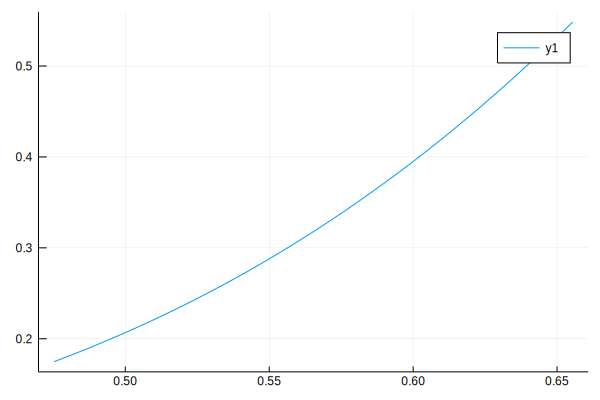

In [29]:
plot(MFAs,divRates)


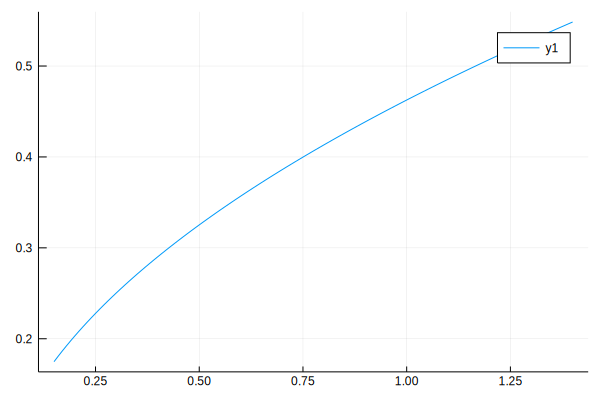

In [20]:
plot(nsRange,lamValues)

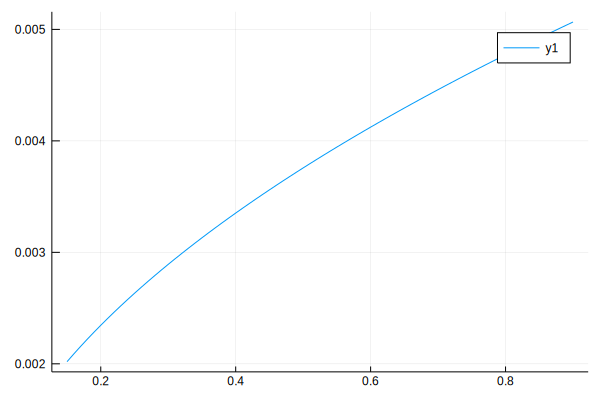

In [6]:
plot(nsRange,lamValues)

In [7]:
divRates = []
riboFractions = []
for t=1:length(sol.t)
    push!(divRates, calculateDivRate(solDF[t,:], parameters))
    push!(riboFractions, calculateMFAllocation(solDF[t, :], parameters)["Ribosomal: "])
end

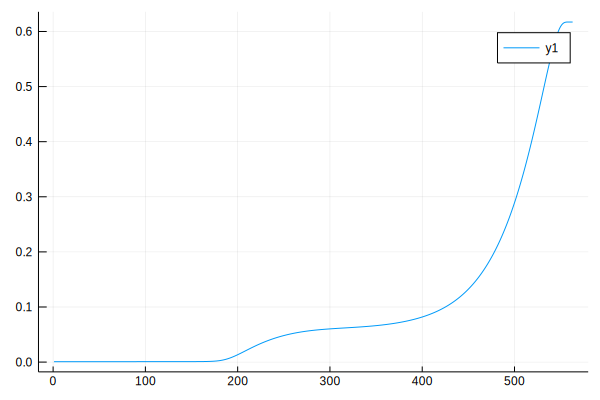

In [8]:
plot(riboFractions)

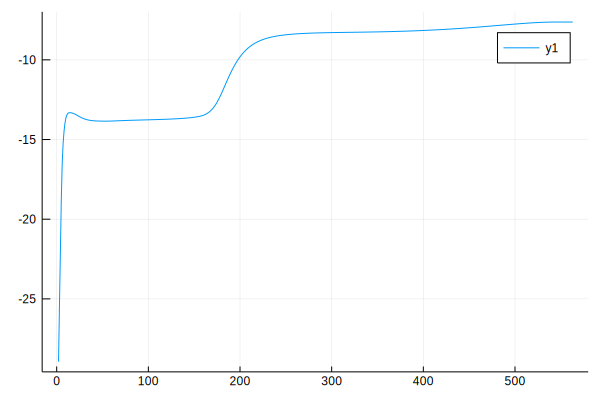

In [9]:
plot(divRates)

In [10]:
divRates

563-element Array{Any,1}:
 -Inf                 
  -28.941019272100398 
  -25.481680513891014 
  -22.147625082810478 
  -18.833707287225838 
  -16.527349355680887 
  -15.246990655830267 
  -14.483474269454375 
  -13.985090914254977 
  -13.6612560030011   
  -13.470281895394203 
  -13.371329657771703 
  -13.32854337039031  
    ⋮                 
   -7.624857068790884 
   -7.62484767866796  
   -7.6248441862649   
   -7.62484316154939  
   -7.624842944477749 
   -7.624842915601407 
   -7.624842913197236 
   -7.624842912803023 
   -7.6248429127663035
   -7.624842912769881 
   -7.624842912769199 
   -7.624842912769322 